This method explores the genre and rating associated with the movie and the customer to develop customer vector based on the content. The recommendations are generated using this customer vector.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval

In [2]:
# Load movies data
movies = pd.read_csv('../5_data/input/movies.csv', converters={"genres": literal_eval})
ratings = pd.read_csv('../5_data/input/ratings.csv')

In [3]:
df = pd.merge(ratings, movies, on = 'tmdbId' , how = 'left')
df = df.drop('original_title', axis = 1)

In [4]:
# Split dataset
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.2, stratify=df.userId)
train_data = train_data.sort_values(['userId', 'tmdbId'])
test_data = test_data.sort_values(['userId','tmdbId'])

In [5]:
# Load the training data
ratings_train = train_data.copy()
# ratings_train = pd.read_csv('../5_data/processed/training_data.csv', converters={"genres": literal_eval})

# ratings_train.head()

In [6]:
# Get unique genres from the data
unique_genre = movies['genres'].explode().unique()

# Make a dict assigning an index to a genre
genre_dict = {k: v for v, k in enumerate(unique_genre)}
genre_dict

{'Animation': 0,
 'Comedy': 1,
 'Family': 2,
 'Adventure': 3,
 'Fantasy': 4,
 'Romance': 5,
 'Drama': 6,
 'Action': 7,
 'Crime': 8,
 'Thriller': 9,
 'Horror': 10,
 'History': 11,
 'Science Fiction': 12,
 'Mystery': 13,
 'War': 14,
 'Foreign': 15,
 nan: 16,
 'Music': 17,
 'Documentary': 18,
 'Western': 19,
 'TV Movie': 20}

In [7]:
# Get the count of each genre
genre_distribution = ratings_train['genres'].explode().value_counts()
genre_distribution

Drama              37573
Comedy             28647
Action             20552
Thriller           20411
Adventure          17458
Romance            15103
Crime              13984
Science Fiction    12102
Fantasy             9981
Family              9447
Mystery             7015
Animation           4903
Horror              4899
History             3185
Music               3151
War                 3057
Western             1279
Documentary         1173
Foreign              163
TV Movie              48
Name: genres, dtype: int64

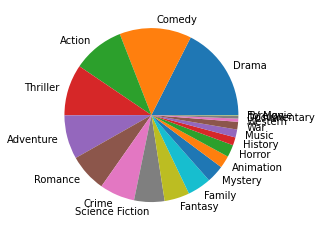

In [8]:
plt.pie(genre_distribution.values, labels = genre_distribution.keys())
plt.show()

In [9]:
movies['movie_vector'] = ""
for ind, row in movies.iterrows():
    genres = row.genres
    movie_vector = np.zeros(len(genre_dict))

    for g in genres:
        movie_vector[genre_dict[g]] = 1
    movies.at[ind, 'movie_vector'] = movie_vector

# Save the final dataframe
movies.to_csv("../5_data/processed/movie_vector.csv")

In [10]:
movies.head()

,tmdbId,original_title,genres,movie_vector
0,862,Toy Story,"[Animation, Comedy, Family]","[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,8844,Jumanji,"[Adventure, Fantasy, Family]","[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
2,15602,Grumpier Old Men,"[Romance, Comedy]","[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
3,31357,Waiting to Exhale,"[Comedy, Drama, Romance]","[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ..."
4,11862,Father of the Bride Part II,[Comedy],"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [37]:
user_ids = ratings_train['userId'].unique()
user_df = pd.DataFrame(columns=['userId', 'user_vector', 'avg_rating', 'num_movies_rated'])
                       
for user_id in user_ids:
#     print(user_id)
    user_rating_df = ratings_train[(ratings_train['userId'] == user_id)]
#     print(user_rating_df)

    user_vector = np.zeros(len(genre_dict))
    count_vector = np.zeros(len(genre_dict))
    
    user_avg_rating = 0
    movies_rated_count = 0
        
    for _, row in user_rating_df.iterrows():
        user_avg_rating += row.rating 
        movies_rated_count += 1
        genres = row.genres
        
        user_movie_vector = np.zeros(len(genre_dict))
        
        if genres:
            for g in genres:
                user_movie_vector[genre_dict[g]] = 1
                count_vector[genre_dict[g]] += 1
                        
        user_vector += user_movie_vector*row.rating

    count_vector = np.where(count_vector==0, 1, count_vector)
    user_vector = np.divide(user_vector, count_vector)
    user_avg_rating /= movies_rated_count
    row_df = pd.DataFrame([[user_id, user_vector, user_avg_rating, movies_rated_count]], 
                          columns=['userId', 'user_vector', 'avg_rating', 'num_movies_rated'])
#     print(row_df)
    user_df = pd.concat([user_df, row_df], ignore_index=True)

In [12]:
user_df

,userId,user_vector,avg_rating,num_movies_rated
0,1,"[2.0, 2.3333333333333335, 3.0, 2.6666666666666...",2.593750,16
1,2,"[3.75, 3.0, 3.3333333333333335, 3.4, 3.2, 3.66...",3.383333,60
2,3,"[2.875, 3.55, 3.0714285714285716, 3.5454545454...",3.646341,41
3,4,"[4.714285714285714, 4.306451612903226, 4.71794...",4.337423,163
4,5,"[3.9375, 3.923076923076923, 4.0, 3.75, 3.85714...",3.906250,80
...,...,...,...,...
666,667,"[4.2, 3.8260869565217392, 4.2, 3.2857142857142...",3.722222,54
667,668,"[3.0, 2.6, 3.0, 3.3333333333333335, 3.0, 0.0, ...",3.533333,15
668,669,"[0.0, 3.2857142857142856, 0.0, 4.5, 2.66666666...",3.400000,30
669,670,"[4.0, 4.0, 4.0, 3.5, 0.0, 4.0, 4.0, 4.0, 4.857...",4.000000,25


In [13]:
# Save the final dataframe
user_df.to_csv("../5_data/processed/user_info.csv")

In [14]:
user_df.head()

,userId,user_vector,avg_rating,num_movies_rated
0,1,"[2.0, 2.3333333333333335, 3.0, 2.6666666666666...",2.593750,16
1,2,"[3.75, 3.0, 3.3333333333333335, 3.4, 3.2, 3.66...",3.383333,60
2,3,"[2.875, 3.55, 3.0714285714285716, 3.5454545454...",3.646341,41
3,4,"[4.714285714285714, 4.306451612903226, 4.71794...",4.337423,163
4,5,"[3.9375, 3.923076923076923, 4.0, 3.75, 3.85714...",3.906250,80


In [17]:
ratings_test = test_data.copy()
ratings_test.head()

,userId,tmdbId,rating,timestamp,genres
442,1,152,2.5,1260759135,"[Science Fiction, Adventure, Mystery]"
535,1,1051,4.0,1260759191,"[Action, Crime, Thriller]"
706,1,8916,2.0,1260759108,"[Adventure, Animation, Comedy, Family]"
806,1,36819,1.0,1260759200,"[Family, Fantasy, Science Fiction, Adventure, ..."
8371,2,268,5.0,835355395,"[Fantasy, Action]"


### Next  few cells for sample test data point

In [18]:
ratings_test.iloc[0]

userId                                           1
tmdbId                                         152
rating                                         2.5
timestamp                               1260759135
genres       [Science Fiction, Adventure, Mystery]
Name: 442, dtype: object

In [28]:
user_rating_df[user_rating_df['tmdbId']==14]

,userId,tmdbId,rating,timestamp,genres
11634,671,14,4.0,1063503841,[Drama]


In [29]:
genres = user_rating_df[user_rating_df['tmdbId']==14].genres.values[0]
vector = np.zeros(len(genre_dict))
for g in genres:
    vector[genre_dict[g]] = 1
print(vector)

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [30]:
user_df[user_df['userId']==1].user_vector[0]

array([2.        , 2.33333333, 3.        , 2.66666667, 0.        ,
       3.75      , 2.5       , 2.6       , 2.5       , 2.5       ,
       3.        , 2.        , 2.83333333, 0.        , 2.        ,
       0.        , 0.        , 0.        , 0.        , 3.        ,
       0.        ])

In [31]:
x = vector*user_df[user_df['userId']==1].user_vector[0]
np.nanmean(np.where(x!=0,x,np.nan)) 

2.5

### Test on entire test data

In [32]:
# Load the already calculated data from csvs

# user_df = pd.read_csv("../5_data/processed/user_info.csv", converters={"user_vector": pd.array})
# movies_df = pd.read_csv("../5_data/processed/movie_vector.csv", converters={"movie_vector": pd.array})

In [38]:
algo_predictions = pd.DataFrame(columns=['userId', 'tmdbId', 'user_vector', 'movie_vector', 'og_rating', 'pred_rating'])
for ind, row in ratings_test.iterrows():
    userId = row['userId']
    tmdbId = row['tmdbId']
    og_rating = row['rating']
    
    try:
        user_vector = user_df[user_df['userId'] == int(userId)].user_vector.values[0]
        movie_vector = movies[movies['tmdbId'] == int(tmdbId)].movie_vector.values[0]

        predicted_rating = user_vector*movie_vector
        
        if predicted_rating.any():
            predicted_rating = np.nanmean(np.where(predicted_rating!=0, predicted_rating, np.nan)) 
        else:
            predicted_rating = 0

        row_df = pd.DataFrame([[userId, tmdbId, user_vector, movie_vector, og_rating, predicted_rating]], 
                    columns=['userId', 'tmdbIdmovieId', 'user_vector', 'movie_vector', 'og_rating', 'pred_rating'])
        algo_predictions = pd.concat([algo_predictions, row_df], ignore_index=True)
    except:
        print("User not found: ", userId)
        
    print(ind, row['userId'])

442 1
535 1
706 1
806 1
8371 2
6141 2
3073 2
8169 2
1440 2
7717 2
7145 2
1692 2
7421 2
4291 2
3289 2
6028 2
3475 2
2007 2
2890 2
4477 3
12445 3
12771 3
11053 3
11200 3
12089 3
10305 3
5418 3
10044 3
11837 3
18230 4
19402 4
23859 4
19201 4
18118 4
14573 4
7933 4
20239 4
17435 4
15349 4
15648 4
17733 4
4818 4
665 4
23519 4
20678 4
20549 4
14908 4
536 4
22283 4
23695 4
22376 4
14248 4
16057 4
5633 4
21616 4
18621 4
22704 4
22871 4
21045 4
4292 4
13902 4
14008 4
21335 4
13090 4
23749 4
23221 4
14540 4
23743 4
21300 4
22161 4
12148 5
4479 5
24603 5
28299 5
14574 5
20240 5
27050 5
29034 5
28384 5
14971 5
7463 5
26863 5
26962 5
28529 5
27517 5
11004 5
25266 5
26014 5
24082 5
25443 5
29911 6
30012 6
29854 6
29386 6
21805 6
30513 6
13184 6
30471 6
29548 6
32498 7
18903 7
444 7
19403 7
1781 7
8373 7
7934 7
32211 7
15649 7
5142 7
9883 7
490 7
32429 7
33207 7
7282 7
1 7
9406 7
12149 8
35423 8
30837 8
34983 8
17635 8
36461 8
27734 8
17359 8
35192 8
1240 8
23137 8
33686 8
28731 8
36073 8
36915 8
230

18911 30
35102 30
39940 30
21912 30
80136 30
49322 30
45055 30
68892 30
37230 30
47422 30
45202 30
60034 30
58580 30
14409 30
6904 30
34117 30
17442 30
76497 30
15358 30
47666 30
74543 30
8180 30
10572 30
10381 30
78903 30
11060 30
14975 30
47535 30
58141 30
4822 30
11212 30
72756 30
45344 30
26866 30
6535 30
72452 30
27465 30
23523 30
7149 30
20680 30
20641 30
71440 30
78353 30
52114 30
22201 30
77366 30
46273 30
27237 30
58452 30
59462 30
46654 30
68650 30
26965 30
71143 30
23697 30
80076 30
33852 30
51765 30
10731 30
16300 30
76230 30
26800 30
41552 30
76793 30
80357 30
53908 30
58520 30
77627 30
75116 30
79732 30
34038 30
56615 30
80058 30
21618 30
53270 30
56746 30
50789 30
50936 30
78798 30
77681 30
76893 30
71342 30
79957 30
54185 30
52779 30
38170 30
41712 30
2364 30
41980 30
78296 30
77914 30
57937 30
77137 30
12900 30
32873 30
80028 30
70518 30
56542 30
48692 30
57837 30
77243 30
54705 30
79976 30
24035 30
11035 30
79289 30
52589 30
41444 30
22120 30
68859 30
79242 30
78282 3

60429 68
78601 68
55428 68
23039 68
32987 68
82605 68
72153 68
74683 68
77963 68
85224 68
74345 68
85222 68
85139 68
12157 69
12288 69
50081 69
15514 69
14982 69
28022 69
20404 69
24445 69
4953 69
24760 69
20934 69
12906 69
24152 69
14479 69
85232 69
41175 69
19211 70
15515 70
42448 70
44223 70
1698 70
43941 70
70160 70
32106 70
85314 70
70481 70
70086 70
44429 70
44651 70
70207 70
70639 70
85320 70
85089 70
53381 71
47443 71
49086 71
46087 71
85349 71
64068 72
32512 72
18417 72
30855 72
34993 72
46876 72
14594 72
63928 72
36681 72
62332 72
27973 72
35504 72
60796 72
17540 72
36315 72
17111 72
63202 72
31290 72
28533 72
64190 72
63732 72
65144 72
64971 72
27146 72
61881 72
64777 72
82787 72
65448 72
39347 72
25453 72
39480 72
66545 72
68264 72
67034 72
84879 72
67617 72
67946 72
68112 72
48306 73
75840 73
64069 73
55815 73
47833 73
43139 73
16544 73
75873 73
40992 73
27615 73
50082 73
87356 73
86600 73
18132 73
14595 73
43406 73
60035 73
51025 73
58581 73
86685 73
6167 73
19814 73
4138

52169 94
58922 94
24454 94
88550 94
27936 94
64361 94
88556 94
27151 94
24159 94
61886 94
83761 94
75978 94
23004 94
65027 94
65512 94
65713 94
66041 94
39353 94
25459 94
13299 95
80040 95
73844 95
26726 95
17369 95
19636 95
88772 95
32243 95
78904 95
53432 95
3187 95
38843 95
75210 95
54290 95
50499 95
72458 95
20686 95
81974 95
41591 95
56993 95
26973 95
22391 95
51745 95
80215 95
79658 95
52170 95
52330 95
58516 95
21435 95
85797 95
47618 95
52385 95
712 95
11007 95
42189 95
768 95
88790 95
76345 95
84584 95
88641 95
71709 95
5602 95
77490 95
80690 95
88698 95
53724 95
51593 95
88608 95
88749 95
80226 95
85943 95
88801 95
80620 95
86010 95
58363 95
88812 95
85699 95
88807 95
88742 95
86021 95
11445 96
45211 96
45729 96
71740 96
45413 96
1469 96
69619 96
54257 96
49708 96
33921 96
72689 96
69562 96
50942 96
88867 96
88865 96
38973 97
17007 97
12468 97
33279 97
14281 97
34807 97
28313 97
12792 97
37249 97
62844 97
46392 97
19637 97
62872 97
46467 97
16761 97
45452 97
63206 97
44460 97

36922 124
58649 124
34047 124
61888 124
4418 124
40245 124
11456 125
63098 125
16561 125
56477 125
29102 125
24630 125
28690 125
50091 125
36851 125
15529 125
36470 125
20266 125
34136 125
17453 125
44977 125
58791 125
11081 125
63207 125
27317 125
61258 125
23151 125
29398 125
25380 125
48777 125
53564 125
16331 125
36082 125
76232 125
27104 125
63907 125
28448 125
4974 125
46765 125
26033 125
48702 125
61889 125
14077 125
65386 125
33606 125
76130 125
65272 125
63581 125
13580 126
8620 126
6193 126
14416 126
937 126
4975 126
43801 126
1143 126
4419 126
70643 126
4090 126
39715 126
13709 126
80569 127
81237 127
4420 127
5306 127
75321 128
34817 128
24632 128
27625 128
35747 128
1826 128
7613 128
6195 128
19818 128
42327 128
26730 128
27978 128
32255 128
36324 128
75211 128
26883 128
5169 128
7166 128
54585 128
54821 128
59378 128
33863 128
35231 128
90919 128
37714 128
52175 128
40750 128
90855 128
56587 128
71343 128
73924 128
89346 128
90905 128
29770 128
3026 128
70136 128
21050 12

90569 160
40406 160
29566 160
77726 160
79253 160
91656 160
78836 160
91642 160
29285 161
7987 161
68665 161
73814 161
4215 161
5650 161
42810 161
24279 161
41996 161
42506 161
42417 161
3300 161
6429 161
12 161
24398 161
70567 161
14081 161
5309 161
33747 162
1710 162
70317 162
25292 162
70435 162
1654 162
13323 163
1838 163
8639 163
9131 163
2270 163
34145 163
11995 163
12619 163
10606 163
7497 163
74176 163
10098 163
5871 163
37897 163
49381 163
66712 163
35903 164
41008 164
45074 164
15533 164
12620 164
44981 164
10421 164
48214 164
30771 164
20423 164
63150 164
61551 164
71652 164
89945 164
69704 164
83860 164
56702 165
34506 165
18937 165
62073 165
36856 165
50195 165
54501 165
8428 165
37269 165
31679 165
19824 165
36698 165
48452 165
6955 165
28169 165
34147 165
26429 165
34708 165
25779 165
15387 165
29713 165
17555 165
30134 165
11088 165
11901 165
11248 165
48561 165
22920 165
22622 165
91720 165
85887 165
85896 165
71148 165
25384 165
2652 165
33865 165
91811 165
4216 165
4

8655 199
8000 199
60108 199
62848 199
12001 199
12624 199
15391 199
57124 199
86843 199
3753 199
955 199
72249 199
39884 199
81904 199
10827 199
23290 199
49623 199
50748 199
63805 199
63866 199
16355 199
60906 199
28546 199
76094 199
39788 199
81854 199
76085 199
86830 199
65151 199
64977 199
92622 199
48870 199
64268 199
59317 199
64508 199
81769 199
65597 199
39308 199
84562 199
28841 199
64549 199
65891 199
92612 199
87099 199
92632 199
92675 199
82755 199
92331 199
76140 199
92670 199
65280 199
65338 199
87045 199
65719 199
65833 199
92623 199
83028 199
66391 199
92688 199
83123 199
66769 199
91341 199
83172 199
92725 199
92743 199
76173 199
92761 199
92766 199
92789 199
92786 199
66429 199
92756 199
67124 199
92625 199
39639 199
81471 199
83306 199
92735 199
60174 200
62074 200
63930 200
28214 200
6232 200
11697 200
12002 200
61408 200
36335 200
40925 200
5188 200
45599 200
63030 200
82568 200
44259 200
62952 200
88949 200
63535 200
27250 200
2657 200
77880 200
26313 200
34057 20

82124 222
93738 222
46210 223
44822 223
70243 223
32448 223
80643 223
70091 223
93747 223
43572 224
959 224
9011 224
93756 224
4223 224
43955 224
41753 224
6041 224
70120 224
3489 224
73031 224
70870 224
4071 224
85014 224
43250 224
42771 224
13736 224
93767 224
2278 225
3764 225
7791 225
2820 225
8933 225
13737 225
27767 226
93320 226
86107 226
63877 226
61044 226
36788 226
92970 226
25982 227
80865 227
92356 227
51116 227
93794 227
13348 228
35917 228
12331 228
16785 228
23557 228
63741 228
61907 228
5318 228
40580 228
65593 228
67677 228
68148 228
47426 229
44986 229
46480 229
75915 229
53280 229
71873 229
36789 229
12484 230
51454 230
29299 230
18287 230
41016 230
53396 230
20283 230
62227 230
34156 230
11263 230
63343 230
30774 230
59273 230
25679 230
49097 230
63492 230
51148 230
93214 230
67928 230
16786 231
3765 231
4851 231
17137 231
47068 231
26990 231
11496 232
47244 232
18951 232
24654 232
74636 232
456 232
19426 232
33066 232
22323 232
50205 232
93686 232
46900 232
45079 2

25494 253
43623 254
43432 254
8020 254
31685 254
2286 254
3097 254
2101 254
44006 254
7188 254
44029 254
42452 254
5395 254
24494 254
3586 254
7432 254
42210 254
12948 254
43228 254
70773 254
92139 254
3358 254
88268 254
88098 254
88077 254
39759 254
88145 254
13064 254
88199 254
69974 255
59249 255
39982 255
35926 255
75811 255
14863 255
69882 255
24949 255
50343 255
84070 255
44275 255
86732 255
36818 255
58417 255
79470 255
24495 255
94481 255
40761 255
94472 255
81195 255
29216 255
40536 255
64715 255
91825 255
88895 255
61101 255
65195 255
94464 255
65127 255
44276 256
32059 256
70139 256
42067 256
69912 256
29126 257
18490 257
35545 257
94492 257
61232 257
46584 257
46970 257
18650 257
82292 257
91550 257
46642 257
82477 257
229 257
82326 257
94512 257
82367 257
46305 257
82312 257
94490 257
94491 257
76174 257
54758 258
77849 258
89494 258
79362 258
48039 258
79345 258
11508 259
14317 259
43433 259
32842 259
12949 259
92187 259
34847 260
28330 260
34165 260
5205 260
36937 260
50

41761 288
43812 288
13943 288
1170 288
9482 288
14095 288
5326 288
54977 289
90369 289
34956 289
81933 289
29306 290
459 290
33105 290
13607 290
25090 290
1324 290
29825 290
88504 290
60914 290
52340 290
37903 290
64803 290
65289 290
48349 291
18503 291
39991 291
17888 291
21503 291
11117 291
19571 291
72465 291
10851 291
29637 291
33558 291
22244 291
52618 291
23423 291
78688 291
23239 291
29573 291
11520 292
34854 292
30919 292
15563 292
8462 292
8695 292
27072 292
73855 292
6999 292
27783 292
37603 292
28175 292
26755 292
51925 292
25801 292
2113 292
32314 292
30177 292
1524 292
971 292
31372 292
59190 292
55010 292
26229 292
59475 292
25400 292
5500 292
30586 292
16385 292
20444 292
18778 292
34069 292
49414 292
21852 292
75861 292
40441 292
85217 292
27897 292
72031 292
5025 292
29218 292
70174 292
43813 292
23424 292
51557 292
33813 292
14195 292
34617 292
2828 292
58200 292
80063 292
87611 292
38247 292
21785 292
5327 292
25502 292
13381 293
30920 293
19363 293
17889 293
15564 2

46781 311
19940 311
44743 311
13947 311
23431 311
84568 311
25316 311
89932 311
74377 311
76472 311
7325 311
59655 311
80798 311
57019 311
36431 311
76363 311
70528 311
57086 311
6723 311
37509 311
83915 311
44573 311
48106 311
85171 311
54706 311
95308 311
94774 311
53534 311
38028 311
77552 311
78961 311
38712 311
71261 311
91873 311
52560 311
90622 311
70297 311
36793 311
95991 311
70774 311
84025 311
92129 311
40672 311
94293 311
24008 311
51606 311
95960 311
45942 311
78689 311
4115 311
45664 311
95372 311
2747 311
90973 311
95897 311
73916 311
49488 311
89607 311
88063 311
77948 311
76979 311
50679 311
72902 311
96037 311
88980 311
43313 311
4073 311
33620 311
95908 311
88860 311
84543 311
89286 311
95947 311
79187 311
93677 311
80388 311
95479 311
91372 311
96040 311
95884 311
96026 311
85149 311
85112 311
95851 311
94413 311
95904 311
90262 311
95811 311
73163 311
92448 311
89389 311
78588 311
93074 311
91164 311
96034 311
95945 311
95819 311
96032 311
91903 311
95926 311
95382

327 353
27383 353
54423 353
5225 353
20145 353
86035 353
143 353
39250 353
61080 353
57870 353
27001 353
78430 353
30594 353
36111 353
36948 353
38643 353
26831 353
28561 353
31814 353
63964 353
41106 353
52197 353
24515 353
63748 353
5925 353
64334 353
37108 353
57913 353
42831 353
93290 353
64128 353
24320 353
32066 353
4347 353
86580 353
20969 353
96268 353
57700 353
38793 353
28847 353
36284 353
69761 353
6446 353
12964 353
24189 353
69633 353
56556 353
56104 353
90137 353
87557 353
96298 353
87463 353
83771 353
69341 353
80169 353
89729 353
94320 353
59748 353
4116 353
14103 353
59689 353
96213 353
90914 353
96249 353
96259 353
96257 353
96253 353
76143 353
80352 353
63598 353
58400 353
15580 354
6863 354
5513 354
24516 354
42013 354
4348 354
43692 354
14104 354
3366 354
5335 354
12502 355
34532 355
62413 355
34869 355
29318 355
40003 355
35041 355
71489 355
50226 355
1903 355
17902 355
25099 355
8721 355
60369 355
8056 355
60118 355
7025 355
49763 355
34740 355
12645 355
15956 35

96661 380
67627 380
67822 380
96667 380
96673 380
68423 380
84474 380
34874 381
24689 381
14667 381
8731 381
17684 381
16812 381
37166 381
22653 381
23321 381
26592 381
20147 381
46288 381
56877 381
77072 381
85574 381
53465 381
56109 381
91992 381
90197 381
71012 381
79946 381
96689 381
46923 382
17685 382
15200 382
34191 382
26468 382
19584 382
56824 382
34433 382
62740 382
63242 382
45324 382
27392 382
63039 382
60017 382
63651 382
62053 382
60866 382
86540 382
20809 382
93331 382
75866 382
73935 382
86193 382
24325 382
5049 382
42016 382
57703 382
77911 382
56909 382
26153 382
61936 382
57499 382
96504 382
21182 382
65196 382
91335 382
21116 382
81847 382
21285 382
60581 382
94584 382
18860 382
90879 382
39300 382
4119 382
84058 382
58752 382
41279 382
96707 382
96694 382
91843 382
95875 382
79704 382
47994 382
91132 382
70898 382
79744 382
83074 382
88718 382
87074 382
95503 382
96742 382
66338 382
1912 383
19249 383
15589 383
32670 383
37167 383
68763 383
5935 383
82176 383
85317

17776 406
61234 406
25702 406
74202 406
87904 406
75531 406
1668 406
82482 406
94326 406
94951 406
56709 407
28940 407
34538 407
30944 407
36224 407
16932 407
22328 407
89154 407
58247 407
11750 407
59963 407
31105 407
3840 407
6814 407
11314 407
48583 407
22085 407
26689 407
74866 407
54645 407
40125 407
22466 407
57568 407
62551 407
77212 407
58942 407
59357 407
62696 407
62618 407
27948 407
49113 407
56256 407
5944 407
37666 407
57807 407
89086 407
57971 407
33821 407
85592 407
45984 407
97164 407
73517 407
69342 407
45949 407
4021 407
23759 407
83955 407
53518 407
77455 407
90020 407
96885 407
2018 407
93608 407
91746 407
90339 407
97184 407
77936 407
80836 407
70980 407
81656 407
88254 407
53207 407
95721 407
93647 407
97185 407
48371 408
33365 408
30441 408
18331 408
46929 408
15433 408
8286 408
48020 408
16208 408
7843 408
31410 408
49526 408
22560 408
20465 408
43021 408
49422 408
72664 408
47945 408
74204 408
41422 408
21462 408
29790 408
81568 408
6103 408
73398 408
85593 408

27588 439
30657 439
88329 439
59416 439
58088 439
40467 439
58136 439
44411 439
56948 439
57976 439
20907 439
76372 439
59056 439
14213 439
56115 439
57347 439
85176 439
21186 439
21322 439
74704 439
80815 439
79896 439
80734 439
58212 439
58423 439
79861 439
49737 439
71545 439
91776 439
71217 439
94973 439
97428 439
7666 440
8758 440
6315 440
3856 440
2530 440
43826 440
9518 440
13801 440
1934 441
14688 441
7667 441
9253 441
28227 441
26771 441
17496 441
2156 441
8296 441
38402 441
10893 441
19788 441
93109 441
57519 441
87727 441
47199 441
71237 441
83774 441
70663 441
45952 441
51166 441
55767 441
88177 441
97446 441
4697 442
28943 442
21580 442
20094 442
21956 442
35981 442
12386 442
27687 442
36889 442
1935 442
17924 442
20325 442
27810 442
34203 442
17497 442
25826 442
84980 442
16823 442
7854 442
5243 442
31429 442
63822 442
33888 442
22472 442
26349 442
20472 442
9987 442
96184 442
5955 442
92181 442
5066 442
42540 442
4363 442
84574 442
25338 442
52040 442
26076 442
12983 442

77793 461
94297 461
61678 461
75191 461
31914 461
50474 461
83982 461
244 461
92857 461
56412 461
88066 461
58486 461
23947 461
83927 461
39738 461
21750 461
56463 461
46185 461
2901 461
79588 461
53524 461
97725 461
70512 461
13807 461
97735 461
78192 461
25231 461
4709 462
19450 462
29656 462
25712 462
22747 462
31580 462
34361 462
2757 462
43333 462
30368 462
88430 463
51478 463
29341 463
35452 463
40022 463
30968 463
35064 463
36239 463
35811 463
91287 463
45111 463
8511 463
6327 463
49772 463
26483 463
15822 463
76511 463
12052 463
51854 463
8303 463
10677 463
19592 463
56830 463
77777 463
58884 463
23189 463
23595 463
7226 463
80495 463
57436 463
30789 463
79491 463
30609 463
10195 463
36128 463
57572 463
55406 463
58265 463
91633 463
9993 463
58949 463
21881 463
27952 463
1084 463
58621 463
5964 463
383 463
40448 463
3614 463
30734 463
47650 463
81028 463
27551 463
3055 463
81074 463
97742 463
44754 463
70492 463
22261 463
79577 463
33229 463
23458 463
83470 463
56912 463
90929 

88485 475
67666 475
68357 475
68407 475
68104 475
98080 475
96668 475
67987 475
68584 475
34903 476
8778 476
53413 476
22670 476
38127 476
51755 476
51303 476
52046 476
89706 476
471 477
81867 477
52355 477
15305 477
48385 478
29344 478
12399 478
28231 478
34760 478
64623 478
64177 478
65962 478
86919 478
65305 478
39415 478
66238 478
87147 478
67720 478
68310 478
12237 479
40025 479
12400 479
77474 479
25002 479
11779 479
19747 479
30252 479
10513 479
7548 479
76124 479
41786 479
77395 479
19900 479
65054 479
41319 479
82944 479
39459 479
66604 479
67288 479
63132 480
35391 480
34904 480
35163 480
12401 480
27698 480
50147 480
61838 480
37057 480
6334 480
17320 480
28423 480
10514 480
53445 480
35694 480
62752 480
3878 480
63254 480
27420 480
7865 480
48269 480
22672 480
58888 480
80496 480
60756 480
96929 480
63354 480
54851 480
20220 480
73616 480
63990 480
75623 480
61862 480
54655 480
64625 480
92953 480
35274 480
62060 480
33990 480
58708 480
61595 480
41120 480
25717 480
48918 4

44157 509
38942 509
51179 509
50444 509
73446 509
10365 509
73052 509
56152 509
29592 509
59201 509
56015 509
89183 509
87981 509
88970 509
96555 509
49595 509
92253 509
48004 509
90537 509
56464 509
85022 509
93611 509
44172 509
97992 509
84529 509
52507 509
70688 509
90343 509
96486 509
71308 509
56393 509
90814 509
55379 509
96869 509
96319 509
81135 509
90541 509
53214 509
30375 509
97736 509
88138 509
40355 509
91301 509
98279 509
96491 509
98262 509
13477 510
20337 510
45871 510
70716 510
39132 510
34221 510
15836 510
68855 510
51951 510
15711 510
72436 510
19137 510
10915 510
26622 510
29535 510
46599 510
6878 510
38590 510
50780 510
46062 510
52977 510
53750 510
45639 510
40679 510
39854 510
77457 510
74048 510
3384 510
53367 510
49572 510
98297 510
96076 510
3130 511
85059 511
24350 511
43283 511
70133 511
4037 511
19014 512
34910 512
63558 512
65966 512
98304 512
9289 513
3890 513
4264 513
24555 513
33073 514
13636 514
19263 514
9290 514
29950 514
19512 514
72562 514
39133 51

29242 534
42040 534
42552 534
80707 534
37867 534
26168 534
43706 534
78979 534
74137 534
70045 534
52527 534
20924 534
38683 534
78967 534
85335 534
43923 534
85249 534
53120 534
38943 534
73462 534
83395 534
29594 534
90821 534
89872 534
98264 534
98461 534
53030 534
25552 534
5792 534
98462 534
88200 534
43479 535
9300 535
3902 535
4909 535
1403 535
2418 535
42553 535
13984 535
13242 535
4459 535
4040 535
73053 535
5793 535
1965 536
9301 536
2336 536
3133 536
3262 536
1600 536
2997 536
80552 536
13895 536
2419 536
70825 536
70923 536
13555 536
13985 536
13010 536
14052 536
9547 536
43070 536
83396 536
88101 536
97030 536
70843 536
19022 537
18583 537
18367 537
19458 537
19266 537
15619 537
9302 537
45287 537
7083 537
25018 537
71944 537
32198 537
45032 537
2181 537
74117 537
70755 537
6827 537
72594 537
29490 537
31470 537
69037 537
47461 537
14953 537
47325 537
89144 537
48837 537
68949 537
33520 537
70708 537
71636 537
72673 537
87729 537
85557 537
42877 537
42996 537
42554 537
70

61314 553
56665 553
61088 553
64767 553
36964 553
67093 553
41126 553
82689 553
86229 553
66524 553
895 553
80520 553
91572 553
41288 553
64917 553
39430 553
66605 553
39511 553
66914 553
39543 553
39648 553
87310 553
83325 553
99028 553
14379 554
7089 554
76520 554
17798 554
11361 554
27278 554
48840 554
79451 554
87799 554
27557 554
83472 554
57271 554
52316 554
7695 555
8813 555
3268 555
4914 555
42455 555
44345 555
9027 555
31854 555
5988 555
68800 555
81615 555
4047 555
43346 555
2029 555
13837 555
6369 556
1607 556
24568 556
2424 556
4385 556
69477 557
58892 557
20816 557
93338 557
28912 557
72633 557
59774 557
13015 557
82648 557
99034 557
84835 557
85094 557
95069 557
30460 558
56363 558
29955 558
46741 558
34768 558
45035 558
57158 558
49809 558
27432 558
79092 558
46602 558
53506 558
26854 558
89753 558
54730 558
40603 558
56775 558
55807 558
76421 558
55330 558
32864 558
56567 558
79792 558
55696 558
57828 558
40614 558
55778 558
48144 558
95315 558
74284 558
40621 558
55617

5105 574
64673 574
56228 574
64881 574
46803 574
28863 574
38315 574
42682 574
14234 574
2873 574
61109 574
64945 574
61050 574
57829 574
43073 574
64492 574
41168 574
4770 575
47896 575
21606 575
71139 575
72321 575
99200 575
45164 575
54031 575
46445 575
74514 575
69070 575
17516 575
74459 575
15070 575
80916 575
74194 575
54331 575
45334 575
27438 575
29494 575
45564 575
23733 575
79889 575
2713 575
79177 575
16490 575
89501 575
73835 575
4273 575
20498 575
31859 575
23122 575
92383 575
77640 575
99192 575
10020 575
16120 575
73150 575
5995 575
40472 575
83598 575
78029 575
90380 575
93959 575
89919 575
51356 575
54231 575
41803 575
70633 575
46804 575
22274 575
83475 575
81662 575
26101 575
94423 575
81754 575
92363 575
53714 575
48121 575
9556 575
21206 575
78970 575
33676 575
43290 575
85535 575
49833 575
89733 575
77487 575
71026 575
73195 575
40509 575
42611 575
79463 575
90626 575
88043 575
56208 575
40733 575
76781 575
79238 575
57400 575
89413 575
87415 575
77672 575
40615 5

5115 596
42257 596
24809 596
20996 596
23486 596
6131 596
26108 596
36292 596
43787 596
6464 596
36454 596
61791 596
55270 596
70538 596
56132 596
61980 596
44643 596
90075 596
48122 596
74741 596
33678 596
81173 596
75993 596
4053 596
90248 596
21799 596
5357 596
13851 596
53035 596
25566 596
48405 597
33423 597
41394 597
14838 597
71951 597
32202 597
47602 597
22988 597
47112 597
10946 597
44954 597
88839 597
47331 597
91548 597
10242 597
68955 597
34018 597
19801 597
94402 597
18815 597
48924 597
80871 597
45498 597
21699 597
22756 597
77241 597
85560 597
48683 597
19180 597
81663 597
93252 597
30507 597
72219 597
21675 597
77523 597
90179 597
99327 597
90267 597
44702 597
95076 597
34931 598
51499 598
27721 598
1989 598
28242 598
10304 598
7111 598
49206 598
16020 598
10548 598
58826 598
15077 598
56668 598
31495 598
81340 598
41543 598
20631 598
27042 598
48849 598
21040 598
10765 598
10243 598
20501 598
75135 598
54732 598
86116 598
27599 598
25740 598
27875 598
58358 598
21475 5

20674 624
41656 624
62968 624
57006 624
77858 624
40980 624
39292 624
12142 624
57884 624
79782 624
46697 624
61712 624
25437 624
55870 624
28773 624
2720 624
86071 624
78038 624
64769 624
53509 624
64025 624
16510 624
36151 624
63787 624
73756 624
78882 624
4279 624
20508 624
99459 624
29674 624
63165 624
82767 624
80222 624
89754 624
21418 624
59449 624
56618 624
5700 624
73153 624
32034 624
12759 624
55969 624
50718 624
54877 624
81732 624
78030 624
56610 624
80662 624
58847 624
30556 624
30758 624
58998 624
62385 624
83822 624
28481 624
52109 624
72047 624
40911 624
50392 624
29249 624
53667 624
23220 624
81760 624
85288 624
95413 624
44775 624
87856 624
83675 624
82218 624
20999 624
59029 624
33247 624
55602 624
25366 624
59670 624
64732 624
38319 624
69769 624
58740 624
76395 624
55272 624
99450 624
56988 624
56135 624
34651 624
57109 624
61988 624
52321 624
53721 624
83921 624
57857 624
80341 624
57356 624
86709 624
90173 624
79793 624
55221 624
20926 624
81618 624
90063 624
521

85727 654
60595 654
74722 654
43079 654
30011 654
75912 654
909 654
78902 654
23027 654
94304 654
24032 654
77067 654
2773 654
14150 654
10372 654
29983 654
89904 654
21802 654
5362 654
40594 654
74888 654
18616 655
12441 655
18391 655
26518 655
25867 655
1636 655
57320 655
69285 655
86721 655
5134 655
41814 655
23497 655
60689 655
34379 655
23966 655
23664 655
65546 655
65743 655
25263 655
83118 655
67302 655
11630 656
40400 656
56378 656
17356 656
46456 656
74461 656
26644 656
41658 656
14968 656
27286 656
26860 656
79455 656
49237 656
55973 656
95292 656
30760 656
48188 656
48756 656
41377 656
30511 656
41457 656
78008 656
22819 656
15326 656
79711 656
99833 656
8562 657
2226 657
24598 657
3644 657
4807 658
45311 658
34261 658
3966 658
73579 658
10344 658
48854 658
2440 658
49517 658
6059 658
95832 658
94802 658
69989 659
13538 659
4808 659
43658 659
15866 659
33488 659
3967 659
37216 659
70764 659
1436 659
68732 659
33784 659
42306 659
4287 659
81280 659
43724 659
71296 659
70947 6

In [39]:
rmse = ((algo_predictions.og_rating - algo_predictions.pred_rating) ** 2).mean() ** .5
rmse

0.9519956022832667

In [40]:
mae = (((algo_predictions.og_rating - algo_predictions.pred_rating) ** 2) ** .5).mean()
mae

0.7374156759426154